# Part1 Chpater03_01 의류 색상 및 종류 분류

## 1. 데이터 불러오기
1) 어노테이션 파일을 불러온다.
2) 데이터의 기본 속성을 파악한다. (데이터 개수, 클래스 개수, 클래스 개수 분포 등)

In [26]:
import os
import pandas as pd

'''
    어노테이션 파일을 불러온다.
'''

data_root = '../datasets/part1_chapter03_02'
annotation_filename = 'annotations.csv'

annotations = pd.read_csv(os.path.join(data_root, annotation_filename))

annotations.head()

,filename,filepath,classes
0,image_26645.jpg,images/image_26645.jpg,"[3, 5]"
1,image_24828.jpg,images/image_24828.jpg,"[1, 3]"
2,image_12280.jpg,images/image_12280.jpg,"[4, 0]"
3,image_7446.jpg,images/image_7446.jpg,"[9, 5]"
4,image_15460.jpg,images/image_15460.jpg,[2]


In [27]:
from collections import defaultdict
import ast
'''
    데이터의 기본 속성을 파악한다. (데이터 개수, 클래스 개수, 클래스 개수 분포 등)
'''

def get_class_map(annotations):
    cls_map = defaultdict(int)
    for idx, annot in annotations.iterrows():
        '''
            csv로 저장되면서 list 데이터가 string으로 변환되어 있음
            예) [1, 2] -> '[1, 2]'
            따라서 ast.literal_eval 함수로 형변환을 해야함
        '''
        cls_list = ast.literal_eval(annot['classes'])
        for cls in cls_list:
            cls_map[cls] += 1
            
    return cls_map

cls_map = get_class_map(annotations)
cls_map

defaultdict(int,
            {3: 386,
             5: 347,
             1: 422,
             4: 364,
             0: 390,
             9: 393,
             2: 395,
             7: 390,
             8: 373,
             6: 360})

In [28]:
print(f'데이터 개수 : {len(annotations)}')
print(f'클래스 개수 : {len(list(cls_map.keys()))}')

데이터 개수 : 2000
클래스 개수 : 10


# 2. 데이터 시각화
 1) 어노테이션을 랜덤으로 섞는다.
 2) 전체 데이터 샘플을 시각화 한다.
 3) 클래스별 데이터 샘플을 시각화 한다.데이터 샘플을 시각화 하여 확인한다.

In [29]:
import matplotlib.pyplot as plt

'''
    이미지 시각화 함수를 정의한다. 
'''
def draw_images(images, classes):
    '''
        :param images: cv2(ndarray) 이미지 리스트
        :param classes: 클래스 리스트
        :return: None 
    '''
    # 4x2의 그리드 생성 (바둑판 이미지 틀 생성)
    fig, axs = plt.subplots(2, 4)
    
    # 각 하위 그래프에 이미지 출력
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i]) # 이미지를 바둑판에 출력
        ax.set_title(classes[i]) # 클래스 이름으로 이미지 제목 생성 
        # ax.axis('off') # 축 숨기기 (이미지 크기 출력 해제)
    
    plt.tight_layout()
    plt.show()

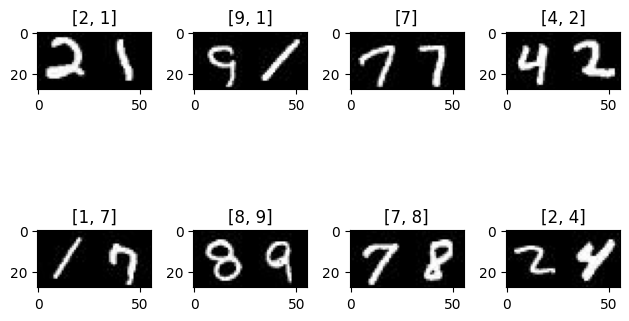

In [30]:
from PIL import Image
import numpy as np
import random

'''
    데이터를 랜덤하게 셔플하고 시각화를 수행한다.
'''

# pandas 데이터프레임을 랜덤하게 셔플하는 방법.
annotations = annotations.sample(frac=1).reset_index(drop=True)

sample_images = [] # 이미지 샘플 저장
sample_classes = [] # 이미지 클래스 저장
sample_cnt = 0 # 시작 count
max_cnt = 8 # 종류 count
for idx, annot in annotations.iterrows():
    classes = annot['classes']
    sample_classes.append(classes)
    image_path = os.path.join(data_root, annot['filepath'])
    image = Image.open(image_path).convert('RGB')
    sample_images.append(np.array(image))
    sample_cnt += 1
    if sample_cnt == max_cnt:
        break

## 전체 데이터 샘플을 시각화 한다.
draw_images(sample_images, sample_classes)

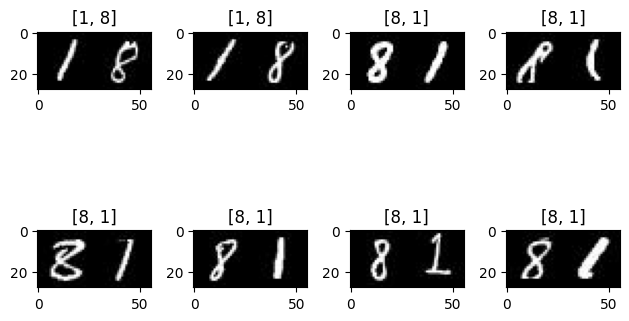

In [31]:
from PIL import Image
import numpy as np
import random

'''
    클래스별 데이터를 시각화 한다.
'''
annotations = annotations.sample(frac=1).reset_index(drop=True)
find_cls = [8, 1] # 찾고자 하는 클래스
sample_images = []
sample_classes = []
sample_cnt = 0
max_cnt = 8
for idx, annot in annotations.iterrows():
    cls_list = ast.literal_eval(annot['classes'])
    if len(cls_list) < 2:
        continue
    cls1, cls2 = cls_list
    ## 찾고자 하는 클래스와 일치할 경우에 데이터를 불러온다.
    if (cls1 in find_cls) and (cls2 in find_cls):
        sample_classes.append(annot['classes'])
        image_path = os.path.join(data_root, annot['filepath'])
        image = Image.open(image_path).convert('RGB')
        sample_images.append(np.array(image))
        sample_cnt += 1
        if sample_cnt == max_cnt:
            break
    else:
        continue

## 클래스별 데이터 샘플을 시각화 한다.
draw_images(sample_images, sample_classes)

# 3. 데이터세트 클래스 생성
1) json 데이터를 파싱하고 출력하는 커스텀 데이터세트 클래스를 생성한다.
2) 데이터세트의 출력 값을 확인한다.

In [32]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

'''
    csv 데이터를 파싱하는 커스텀 데이터세트 클래스를 선언한다.
'''

class CsvDataset(Dataset):
    def __init__(self, 
                 data_root,
                 annotations, 
                 transform=None):
        '''
            :param data_root: 데이터셋의 루트 경로 
            :param annotations: 어노테이션
            :param transform: 이미지 변환 모듈
        '''
        self.data_root = data_root
        self.annotations = annotations
        self.transform = transform
        self.class_list = self._get_classes() # 클래스의 목록
        self.num_classes = len(self.class_list) # 클래스 개수
        
    def __len__(self):
        return len(self.annotations) # 데이터 개수

    def __getitem__(self, idx):
        '''
            :param idx:  
            :return:
                image : 입력 이미지 데이터 (텐서 또는 pillow 이미지)
                target : 정답 클래스 데이터 (원-핫 벡터)
                    예) [1.0, 0.0, 0.0, 1.0, 0.0, ...]
        '''
        annot = self.annotations.iloc[idx]
        image_path = os.path.join(self.data_root, annot['filepath'])
        image = Image.open(image_path).convert("RGB")
        classes = ast.literal_eval(annot['classes'])
        target = []
        for cls in classes:
            target.append(self.class_list.index(cls))
        target = F.one_hot(torch.tensor(target), self.num_classes).sum(dim=0).to(torch.float)
        
        if self.transform:
            image = self.transform(image)

        return image, target
    
    def _get_classes(self):
        '''
        :return: 클래스의 리스트를 반환한다. 각 인덱스는 클래스 번호가 된다.
            예) ['blue', 'shirts', 'dress', ...] => blue: 0번 클래스, shirts: 1번 클래스, ... 
        '''
        class_set = set()
        for idx, annot in self.annotations.iterrows():
            cls_list = ast.literal_eval(annot['classes'])
            for cls in cls_list:
                class_set.add(cls)
        class_list = list(class_set)
        class_list.sort()
        return class_list

In [33]:
'''
    데이터세트의 출력 값을 시각화 한다.
'''
dataset = CsvDataset(data_root=data_root,
                     annotations=annotations)
data = dataset[0]
data[0]

In [34]:
print(data[1])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])


# 4. 학습 및 검증 데이터 분할

In [35]:
'''
    원본 데이터셋을 학습과 검증셋으로 분할한다.
'''
annotations = annotations.sample(frac=1).reset_index(drop=True)
len_annot = len(annotations)
train_annot = annotations.iloc[ : int(len_annot * 0.9)]
val_annot = annotations.iloc[int(len_annot * 0.9) : ]

print(f'학습 데이터 개수 : {len(train_annot)}')
print(f'검증 데이터 개수 : {len(val_annot)}')

학습 데이터 개수 : 1800
검증 데이터 개수 : 200


# 5. 모델 학습 준비
1. 학습에 필요한 하이퍼파라미터를 선언한다.
2. 이미지 변환 모듈을 적용한 데이터세트의 샘플을 확인한다.
3. 이미지 변환 모듈을 적용한 학습 및 검증 데이터세트를 생성한다.
4. 학습 및 검증 데이터 로더를 생성한다.


In [36]:
'''
    학습에 필요한 하이퍼파라미터를 선언한다.
'''
hyper_params = {
    'num_epochs': 5,
    'lr': 0.0001,
    'score_threshold': 0.5, # 모델의 출력값에 대한 임계값
    'image_size': 112,
    'train_batch_size': 8,
    'val_batch_size': 4,
    'print_preq': 0.1 # 학습 중 로그 출력 빈도
}

In [37]:
from torchvision import transforms

'''
    이미지 변환 모듈을 적용한 데이터세트의 결과물을 확인한다.
'''
# 샘플 이미지 변환 모듈 설정
sample_transform = transforms.Compose([
    transforms.Resize((hyper_params['image_size'], hyper_params['image_size'])),
    transforms.RandomRotation(degrees=15),
    # transforms.ToTensor(), # 테스트 과정에서 사용하지 않음.
])
sample_dataset = CsvDataset(data_root, train_annot, sample_transform)


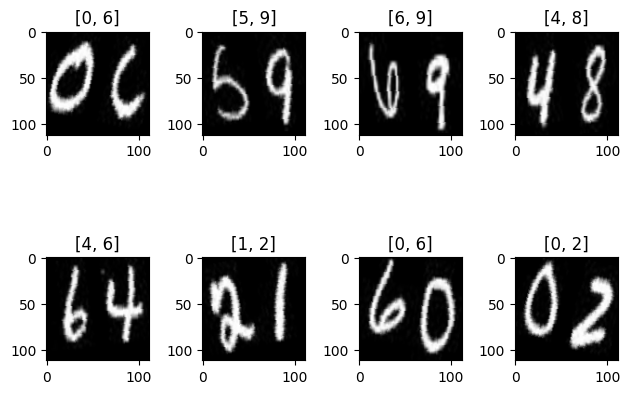

In [38]:
transformed_images = []
targets = []

## 데이터세트에서 변환된 이미지와 target 벡터를 불러온다.
max_cnt = 8
for idx, (image, target) in enumerate(sample_dataset):
    if idx == max_cnt:
        break
    transformed_images.append(image)
    targets.append(target.tolist())

## 타켓 벡터를 클래스로 변환하고 
target_classes = []
class_list = sample_dataset.class_list
for target in targets:
    classes = []
    for cls, val in enumerate(target):
        if int(val) == 1:
            classes.append(class_list[cls])
    target_classes.append(classes)

draw_images(transformed_images, target_classes)

In [39]:
'''
    이미지 변환 모듈을 적용한 학습 및 검증 데이터세트를 생성한다.
    학습 및 검증 데이터 로더를 생성한다.
'''


# 학습 및 검증 이미지 변환 모듈 설정
transform = transforms.Compose([
    transforms.Resize((hyper_params['image_size'], hyper_params['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

# 학습 데이터세트 및 데이터로더 설정
train_dataset = CsvDataset(data_root, train_annot, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hyper_params['train_batch_size'], shuffle=True)

# 검증 데이터세트 및 데이터로더 설정
val_dataset = CsvDataset(data_root, train_annot, transform)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hyper_params['val_batch_size'], shuffle=False)

# 6. 모델 생성
1) Resnet18 모델을 불러온다.
2) 클래스 개수에 맞게 출력 레이어를 변경한다.

In [40]:
import torch
import torch.nn as nn
from torchvision import models

'''
    1. Resnet18 모델을 불러온다.
    2. 클래스 개수에 맞게 출력 레이어를 변경한다.
'''

model = models.resnet18(pretrained=True)
model

/opt/homebrew/anaconda3/envs/lecture/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/lecture/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [42]:
model.fc = nn.Linear(512, train_dataset.num_classes)

In [43]:
'''
    모델을 불러오는 함수를 정의한다.
'''
def get_model(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(512, num_classes)
    
    return model
    
model = get_model(num_classes=train_dataset.num_classes)

/opt/homebrew/anaconda3/envs/lecture/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/lecture/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 7. 모델 학습 및 검증
   1) loss함수와 옵티마이저를 설정한다.
   2) 학습 루프를 실행한다.
   3) 1 epoch 마다 검증 루프를 실행한다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

# loss 함수와 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=hyper_params['lr'])

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = hyper_params['num_epochs']
model_save_dir = './train_results' # epoch 마다 모델 weight를 저장한다.
os.makedirs(model_save_dir, exist_ok=True)
# 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print_cnt = int(len(train_dataloader) * hyper_params['print_preq'])

    for idx, (images, targets) in enumerate(train_dataloader):
        images, targets = images.to(device), targets.to(device)
        
        # 순전파
        outputs = model(images)
        loss = criterion(outputs, targets)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        
        if idx % print_cnt == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Iter [{idx}/{len(train_dataloader)}] "
                  f"Loss: {running_loss/print_cnt:.4f}")
            running_loss = 0.0
        
        

    # 한 epoch이 끝날 때마다 손실값 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")
    
    # 한 epoch이 끝날 때마다 model weight 저장
    model_save_path = os.path.join(model_save_dir, f'{epoch}_model.pth')
    torch.save(model.state_dict(), model_save_path)

    # F1-score 계산 및 출력
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > hyper_params['score_threshold']).float()  # threshold 설정, 여기서는 0.5로 가정
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='micro')  # F1-score 계산
    print(f"F1-score: {f1:.4f}")

In [ ]:
f1_score(y_true, y_pred, average=None)

In [ ]:
import json

'''
    학습 결과 모델과 하이퍼파라미터를 저장한다.
'''

model_save_dir = './train_results'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'model.pth')

torch.save(model.state_dict(), model_save_path)

param_save_path = os.path.join(model_save_dir, 'hyper_params.json') 
with open(param_save_path, 'w')as json_f:
    json.dump(hyper_params, json_f, indent='\t', ensure_ascii=False)

# 8. 모델 테스트
1) 학습한 모델의 가중치를 불러온다.
2) 모델 추론 결과를 확인한다.

In [ ]:
'''
    모델을 선언하고 학습한 모델의 가중치를 불러온다.
'''

model_filename = 'model.pth'

model = get_model(num_classes=train_dataset.num_classes)
model.load_state_dict(torch.load(os.path.join(model_save_dir, model_filename), map_location='cpu'))

In [ ]:
'''
    모델의 추론을 수행한다.
'''
image_list = []
pred_list = []

val_cnt = 8
iter_cnt = 0
for idx, annot in val_annot.iterrows():
    if iter_cnt == val_cnt:
        break
    image_path = os.path.join(data_root, annot['filepath'])
    print(f'image_path : {image_path}')
    image = Image.open(image_path)
    image_list.append(image)
    input_image = transform(image).unsqueeze(0).to(device)
    
    outputs = torch.sigmoid(model(input_image))[0]
    preds = (outputs > hyper_params['score_threshold']).int().tolist() # threshold 설정
    pred_list.append(preds)
    
    iter_cnt += 1

In [ ]:
'''
    모델의 추론 결과(클래스 번호)를 클래스 이름으로 변경한다
'''
class_list = train_dataset.class_list
pred_class_list = []
for pred in pred_list:
    pred_class = []
    for cls, val in enumerate(pred):
        if int(val) == 1:
            pred_class.append(class_list[cls])
    pred_class_list.append(pred_class)


In [ ]:
draw_images(image_list, pred_class_list)